# Unit10_ElasticNet_Regression | 副標題：L1+L2 混合正則化與穩定特徵選擇

本 Notebook 使用模擬的化學反應數據建立 **Elastic Net 回歸模型**，展示混合正則化的核心優勢：**穩定的特徵選擇** + **處理多重共線性**。

## 目標
- 理解 Elastic Net 回歸的混合正則化原理（L1 + L2）
- 使用 **ElasticNetCV** 進行最佳 α 和 l1_ratio 參數選擇
- 展示 Elastic Net 如何處理相關特徵（群組效應）
- 比較 Elastic Net、Lasso、Ridge、OLS 四種模型
- 視覺化正則化路徑
- 評估模型性能與穩定性

## 數據設計
本案例特別設計了 **10 個特徵**：
- **4 個重要特徵**：溫度、壓力、催化劑濃度、反應時間（真實影響產率）
- **2 組高度相關特徵**（測試群組效應）：
  * 溫度相關組：T1_inlet, T2_outlet（相關係數 > 0.9）
  * 壓力相關組：P1_inlet, P2_outlet（相關係數 > 0.9）
- **2 個冗餘特徵**：攪拌速度、pH（不影響產率）

**目標**：驗證 Elastic Net 能否穩定地處理相關特徵群組。

## 關鍵特色
- ✅ L1 + L2 混合正則化
- ✅ 群組效應（相關特徵傾向一起進出）
- ✅ 比 Lasso 更穩定的特徵選擇
- ✅ 處理多重共線性
- ✅ 適合相關特徵眾多的化工數據

---
## 0. 環境設定

In [1]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P3_Unit10_ElasticNet_Regression'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")

try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_3' / 'Unit10'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit10
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit10\outputs\P3_Unit10_ElasticNet_Regression
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit10\outputs\P3_Unit10_ElasticNet_Regression\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit10\outputs\P3_Unit10_ElasticNet_Regression\figs


---
## 1. 載入相關套件

In [2]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib

# sklearn 線性模型
from sklearn.linear_model import (
    ElasticNet, ElasticNetCV,  # Elastic Net 模型
    Lasso, Ridge, LinearRegression,  # 比較用模型
    enet_path  # 正則化路徑計算
)

# 資料處理與評估
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 視覺化設定
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

# 隨機種子
np.random.seed(42)

print("✓ 套件載入完成")

✓ 套件載入完成


---
## 2. 產生模擬數據

本案例設計了**10個特徵**，包含：
- 4個重要特徵（真實影響產率）
- 2組高度相關特徵（測試群組效應）
- 2個冗餘特徵（不影響產率）

**真實模型**：

$$
\text{Yield} = 50 + 0.6 \cdot T + 3.5 \cdot P + 5.0 \cdot C + 0.08 \cdot t + \epsilon
$$

其中 $\epsilon \sim N(0, 3^2)$ 為隨機噪音。

**關鍵設計**：
- T1_inlet 和 T2_outlet 高度相關（r > 0.9）
- P1_inlet 和 P2_outlet 高度相關（r > 0.9）
- 目的：測試 Elastic Net 的群組效應

In [4]:
# 設定樣本數
n_samples = 500

# ========================================
# 1. 生成4個重要特徵（基礎操作參數）
# ========================================
temperature = np.random.uniform(80, 120, n_samples)  # 溫度 80-120°C
pressure = np.random.uniform(1, 5, n_samples)        # 壓力 1-5 bar
catalyst = np.random.uniform(0.5, 2.5, n_samples)    # 催化劑 0.5-2.5 wt%
time = np.random.uniform(30, 180, n_samples)         # 時間 30-180 min

# ========================================
# 2. 生成相關特徵組（測試群組效應）
# ========================================
# 溫度相關組：T1_inlet 和 T2_outlet 高度相關
T1_inlet = temperature + np.random.normal(0, 2, n_samples)  # 入口溫度
T2_outlet = temperature + np.random.normal(0, 2, n_samples)  # 出口溫度
correlation_T = np.corrcoef(T1_inlet, T2_outlet)[0, 1]

# 壓力相關組：P1_inlet 和 P2_outlet 高度相關
P1_inlet = pressure + np.random.normal(0, 0.1, n_samples)  # 入口壓力
P2_outlet = pressure + np.random.normal(0, 0.1, n_samples)  # 出口壓力
correlation_P = np.corrcoef(P1_inlet, P2_outlet)[0, 1]

# ========================================
# 3. 生成冗餘特徵（不影響產率）
# ========================================
stirring_speed = np.random.uniform(200, 500, n_samples)  # 攪拌速度
ph = np.random.uniform(6.0, 8.0, n_samples)              # pH值

# ========================================
# 4. 計算目標變數（產率）
# ========================================
# 真實模型係數
true_intercept = 50.0
true_coef_temp = 0.6
true_coef_pressure = 3.5
true_coef_catalyst = 5.0
true_coef_time = 0.08

# 真實產率（僅受4個重要特徵影響）
true_yield = (true_intercept + 
              true_coef_temp * temperature +
              true_coef_pressure * pressure +
              true_coef_catalyst * catalyst +
              true_coef_time * time)

# 加入隨機噪音
noise = np.random.normal(0, 3, n_samples)
yield_percent = true_yield + noise

# ========================================
# 5. 建立 DataFrame
# ========================================
df = pd.DataFrame({
    'Temperature_C': temperature,
    'Pressure_bar': pressure,
    'Catalyst_wt%': catalyst,
    'Time_min': time,
    'T1_inlet_C': T1_inlet,
    'T2_outlet_C': T2_outlet,
    'P1_inlet_bar': P1_inlet,
    'P2_outlet_bar': P2_outlet,
    'Stirring_Speed_rpm': stirring_speed,
    'pH': ph,
    'Yield_%': yield_percent
})

print("="*70)
print("\n模擬數據生成完成")


模擬數據生成完成


In [5]:
print("="*70)
print(f"樣本數: {n_samples}")
print(f"特徵數: {df.shape[1] - 1}")
print("="*70)
print("\n數據前5行:")
print(df.head())
print("\n數據摘要統計:")
print(df.describe())

# 顯示相關特徵組的相關係數
print("\n" + "="*70)
print("相關特徵組的相關性驗證")
print("="*70)
print(f"  T1_inlet 與 T2_outlet 相關係數: {correlation_T:.4f}")
print(f"  P1_inlet 與 P2_outlet 相關係數: {correlation_P:.4f}")
print("\n✓ 兩組特徵都高度相關（r > 0.9），符合設計要求")
print("  目的：測試 Elastic Net 的群組效應")

樣本數: 500
特徵數: 10

數據前5行:
   Temperature_C  Pressure_bar  Catalyst_wt%    Time_min  T1_inlet_C  \
0      94.981605      3.792647      0.870266  107.862268   93.225640   
1     118.028572      3.144385      1.583802  101.877282  116.374812   
2     109.279758      2.238110      2.245892   33.846310  108.826800   
3     103.946339      4.255180      1.964450   81.187174  104.681070   
4      86.240746      3.738925      2.113122   87.029343   88.067915   

   T2_outlet_C  P1_inlet_bar  P2_outlet_bar  Stirring_Speed_rpm        pH  \
0    93.665372      3.979743       3.763792          379.789786  6.787271   
1   117.421120      3.183347       3.066010          354.112357  6.946871   
2   106.588016      2.151281       2.411604          286.455358  7.709095   
3   102.307824      4.308643       4.169503          201.939307  6.680009   
4    85.288304      3.475350       3.683370          348.871767  7.739299   

      Yield_%  
0  131.281842  
1  147.973625  
2  137.196292  
3  138.831626  

---
## 3. 探索性數據分析 (EDA)

### 3.1 相關性分析

重點觀察：
- 4個重要特徵與產率的相關性（應該較高）
- 相關特徵組內部的相關性（T1/T2、P1/P2）
- 冗餘特徵與產率的相關性（應該接近0）

特徵與產率的 Pearson 相關係數（絕對值排序）
  Temperature_C       : 0.719053
  T1_inlet_C          : 0.708181
  T2_outlet_C         : 0.706334
  Pressure_bar        : 0.413763
  P2_outlet_bar       : 0.413615
  P1_inlet_bar        : 0.410019
  Catalyst_wt%        : 0.351872
  Time_min            : 0.347563
  Stirring_Speed_rpm  : 0.011980
  pH                  : 0.007587

觀察結果
✓ 4個重要特徵（Temperature, Pressure, Catalyst, Time）相關性最高
✓ 相關特徵組（T1/T2, P1/P2）與產率也有相關性（因為來自重要特徵）
✓ 冗餘特徵（Stirring_Speed, pH）相關性接近0


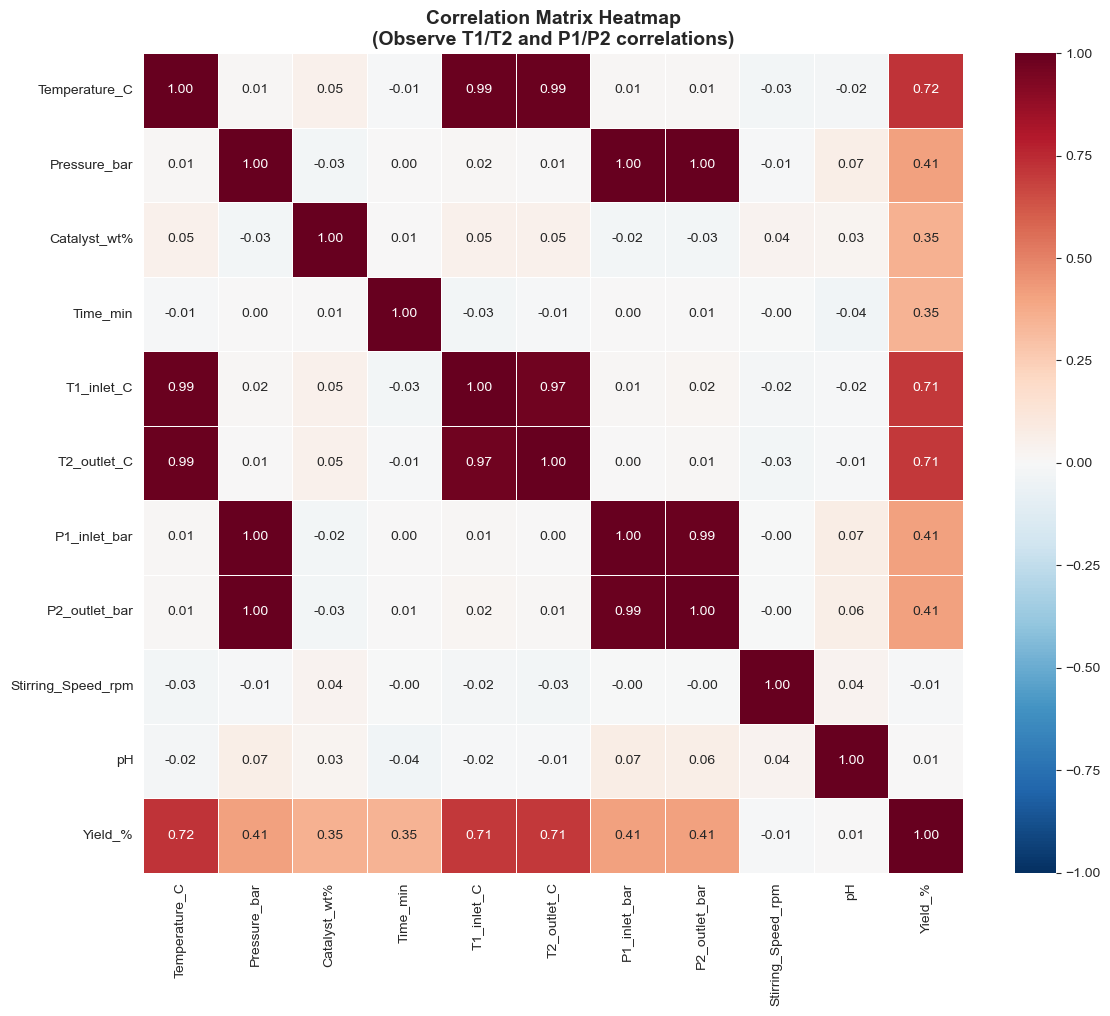


✓ 相關性矩陣已儲存至 d:\MyGit\CHE-AI-COURSE\Part_3\Unit10\outputs\P3_Unit10_ElasticNet_Regression\figs\correlation_matrix.png


In [6]:
# 計算相關性矩陣
correlation_matrix = df.corr()

# 提取與產率的相關性
correlations_with_yield = correlation_matrix['Yield_%'].drop('Yield_%').abs().sort_values(ascending=False)

print("="*70)
print("特徵與產率的 Pearson 相關係數（絕對值排序）")
print("="*70)
for feature, corr in correlations_with_yield.items():
    print(f"  {feature:20s}: {corr:.6f}")

print("\n" + "="*70)
print("觀察結果")
print("="*70)
print("✓ 4個重要特徵（Temperature, Pressure, Catalyst, Time）相關性最高")
print("✓ 相關特徵組（T1/T2, P1/P2）與產率也有相關性（因為來自重要特徵）")
print("✓ 冗餘特徵（Stirring_Speed, pH）相關性接近0")

# 繪製相關性矩陣熱力圖
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title('Correlation Matrix Heatmap\n(Observe T1/T2 and P1/P2 correlations)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 相關性矩陣已儲存至 {FIG_DIR / 'correlation_matrix.png'}")

### 3.2 相關特徵組視覺化

繪製散點圖觀察相關特徵組的線性關係。

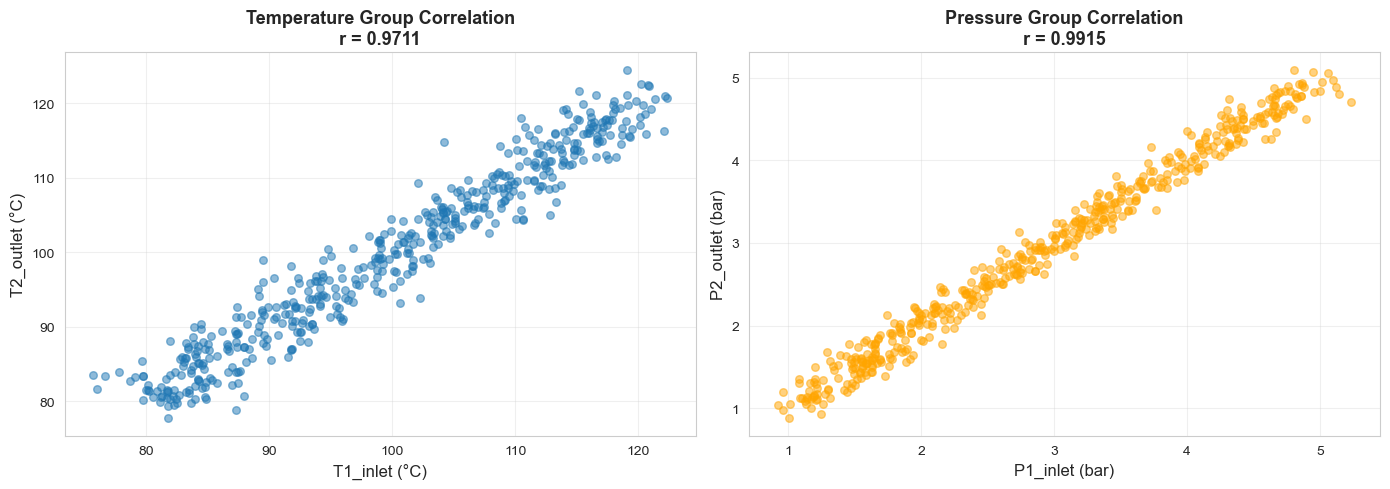

✓ 相關特徵組散點圖已儲存至 d:\MyGit\CHE-AI-COURSE\Part_3\Unit10\outputs\P3_Unit10_ElasticNet_Regression\figs\correlated_feature_groups.png

觀察：兩組特徵都呈現明顯的線性關係，符合高相關性設計


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 溫度相關組
axes[0].scatter(df['T1_inlet_C'], df['T2_outlet_C'], alpha=0.5, s=30)
axes[0].set_xlabel('T1_inlet (°C)', fontsize=12)
axes[0].set_ylabel('T2_outlet (°C)', fontsize=12)
axes[0].set_title(f'Temperature Group Correlation\nr = {correlation_T:.4f}', 
                  fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)

# 壓力相關組
axes[1].scatter(df['P1_inlet_bar'], df['P2_outlet_bar'], alpha=0.5, s=30, color='orange')
axes[1].set_xlabel('P1_inlet (bar)', fontsize=12)
axes[1].set_ylabel('P2_outlet (bar)', fontsize=12)
axes[1].set_title(f'Pressure Group Correlation\nr = {correlation_P:.4f}', 
                  fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'correlated_feature_groups.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 相關特徵組散點圖已儲存至 {FIG_DIR / 'correlated_feature_groups.png'}")
print("\n觀察：兩組特徵都呈現明顯的線性關係，符合高相關性設計")

---
## 4. 數據預處理

### 4.1 分離特徵與目標變數

In [8]:
# 分離特徵與目標
X = df.drop('Yield_%', axis=1)
y = df['Yield_%']

print("="*70)
print("數據分離完成")
print("="*70)
print(f"特徵矩陣 X: {X.shape}")
print(f"目標變數 y: {y.shape}")
print(f"\n特徵列表:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i}. {col}")

數據分離完成
特徵矩陣 X: (500, 10)
目標變數 y: (500,)

特徵列表:
  1. Temperature_C
  2. Pressure_bar
  3. Catalyst_wt%
  4. Time_min
  5. T1_inlet_C
  6. T2_outlet_C
  7. P1_inlet_bar
  8. P2_outlet_bar
  9. Stirring_Speed_rpm
  10. pH


### 4.2 訓練集/測試集切分

In [9]:
# 切分訓練集與測試集（80/20）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("="*70)
print("訓練集/測試集切分完成")
print("="*70)
print(f"訓練集: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"測試集: X_test {X_test.shape}, y_test {y_test.shape}")
print(f"切分比例: 80% / 20%")

訓練集/測試集切分完成
訓練集: X_train (400, 10), y_train (400,)
測試集: X_test (100, 10), y_test (100,)
切分比例: 80% / 20%


### 4.3 特徵標準化（Elastic Net 必須！）

Elastic Net 的懲罰項對所有係數一視同仁，因此**必須標準化**，否則懲罰效果會因特徵尺度不同而不均勻。

In [10]:
# 建立標準化器
scaler = StandardScaler()

# 訓練集標準化（fit + transform）
X_train_scaled = scaler.fit_transform(X_train)

# 測試集標準化（僅 transform）
X_test_scaled = scaler.transform(X_test)

print("="*70)
print("特徵標準化完成")
print("="*70)
print(f"標準化後訓練集: {X_train_scaled.shape}")
print(f"標準化後測試集: {X_test_scaled.shape}")
print(f"\n標準化統計（訓練集）:")
print(f"  均值: {X_train_scaled.mean(axis=0).mean():.6f} (應接近 0)")
print(f"  標準差: {X_train_scaled.std(axis=0).mean():.6f} (應接近 1)")

特徵標準化完成
標準化後訓練集: (400, 10)
標準化後測試集: (100, 10)

標準化統計（訓練集）:
  均值: 0.000000 (應接近 0)
  標準差: 1.000000 (應接近 1)


---
## 5. 選擇最佳參數 α 和 l1_ratio

使用 **ElasticNetCV** 進行 5-Fold 交叉驗證，自動選擇最佳的：
- **α (alpha)**：總正則化強度
- **l1_ratio**：L1 和 L2 的混合比例
  - l1_ratio = 0：純 Ridge
  - l1_ratio = 1：純 Lasso
  - 0 < l1_ratio < 1：Elastic Net（混合）

In [11]:
# 定義候選值
alphas = np.logspace(-4, 1, 100)  # 100個 α 候選值（0.0001 到 10）
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]  # 7個 l1_ratio 候選值

# 使用 ElasticNetCV 進行交叉驗證
enet_cv = ElasticNetCV(
    alphas=alphas,
    l1_ratio=l1_ratios,
    cv=5,  # 5-fold 交叉驗證
    max_iter=10000,
    n_jobs=-1,  # 使用所有 CPU
    random_state=42
)

# 訓練模型（同時進行參數選擇）
enet_cv.fit(X_train_scaled, y_train)

# 提取最佳參數
best_alpha = enet_cv.alpha_
best_l1_ratio = enet_cv.l1_ratio_
n_selected_features = np.sum(enet_cv.coef_ != 0)

print("="*70)
print("ElasticNetCV 交叉驗證結果")
print("="*70)
print(f"最佳 α (總正則化強度): {best_alpha:.6f}")
print(f"最佳 l1_ratio (L1比例): {best_l1_ratio:.2f}")
print(f"  → L1 懲罰權重: {best_l1_ratio * 100:.0f}%")
print(f"  → L2 懲罰權重: {(1-best_l1_ratio) * 100:.0f}%")
print(f"測試的 α 範圍: [{alphas.min():.6f}, {alphas.max():.6f}]")
print(f"測試的 l1_ratio 範圍: {l1_ratios}")
print(f"選定特徵數: {n_selected_features}/{len(X.columns)}")
print("="*70)

ElasticNetCV 交叉驗證結果
最佳 α (總正則化強度): 0.047508
最佳 l1_ratio (L1比例): 0.99
  → L1 懲罰權重: 99%
  → L2 懲罰權重: 1%
測試的 α 範圍: [0.000100, 10.000000]
測試的 l1_ratio 範圍: [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]
選定特徵數: 8/10


---
## 6. 訓練 Elastic Net 回歸模型

使用最佳 α 和 l1_ratio 訓練最終模型。

In [12]:
# 建立 Elastic Net 模型
enet_model = ElasticNet(
    alpha=best_alpha,
    l1_ratio=best_l1_ratio,
    max_iter=10000,
    random_state=42
)

# 訓練模型
enet_model.fit(X_train_scaled, y_train)

print("✓ Elastic Net 模型訓練完成")
print(f"\n截距 (β₀): {enet_model.intercept_:.4f}")
print(f"\n回歸係數 (β):")

for feature, coef in zip(X.columns, enet_model.coef_):
    status = "[✓ 保留]" if coef != 0 else "[✗ 剔除]"
    print(f"  {feature:20s}: {coef:8.4f}  {status}")

✓ Elastic Net 模型訓練完成

截距 (β₀): 136.3626

回歸係數 (β):
  Temperature_C       :   5.4130  [✓ 保留]
  Pressure_bar        :   4.0443  [✓ 保留]
  Catalyst_wt%        :   3.0789  [✓ 保留]
  Time_min            :   3.5755  [✓ 保留]
  T1_inlet_C          :   0.9898  [✓ 保留]
  T2_outlet_C         :   0.5501  [✓ 保留]
  P1_inlet_bar        :   0.0000  [✗ 剔除]
  P2_outlet_bar       :   0.0000  [✗ 剔除]
  Stirring_Speed_rpm  :   0.0502  [✓ 保留]
  pH                  :  -0.1628  [✓ 保留]


---
## 7. 特徵選擇結果分析

### 7.1 查看選定與剔除的特徵

**重點觀察**：Elastic Net 如何處理相關特徵組（T1/T2, P1/P2）

In [13]:
# 獲取選定和剔除的特徵
selected_features = X.columns[enet_model.coef_ != 0]
eliminated_features = X.columns[enet_model.coef_ == 0]

print("="*70)
print("Elastic Net 特徵選擇結果")
print("="*70)
print(f"\n選定特徵 ({len(selected_features)} 個):")
for i, feature in enumerate(selected_features, 1):
    coef = enet_model.coef_[X.columns.get_loc(feature)]
    print(f"  {i}. {feature:20s}: {coef:8.4f}")

print(f"\n剔除特徵 ({len(eliminated_features)} 個):")
for i, feature in enumerate(eliminated_features, 1):
    print(f"  {i}. {feature}")

print("\n" + "="*70)
print("群組效應觀察")
print("="*70)
# 檢查相關特徵組的係數
T1_coef = enet_model.coef_[X.columns.get_loc('T1_inlet_C')]
T2_coef = enet_model.coef_[X.columns.get_loc('T2_outlet_C')]
P1_coef = enet_model.coef_[X.columns.get_loc('P1_inlet_bar')]
P2_coef = enet_model.coef_[X.columns.get_loc('P2_outlet_bar')]

print(f"溫度相關組:")
print(f"  T1_inlet:  {T1_coef:8.4f}")
print(f"  T2_outlet: {T2_coef:8.4f}")
if T1_coef != 0 and T2_coef != 0:
    print(f"  → 兩者都保留，係數差異: {abs(T1_coef - T2_coef):.4f}")
    print(f"  ✓ 展現群組效應（傾向一起選擇）")
else:
    print(f"  → 至少一個被剔除")

print(f"\n壓力相關組:")
print(f"  P1_inlet:  {P1_coef:8.4f}")
print(f"  P2_outlet: {P2_coef:8.4f}")
if P1_coef != 0 and P2_coef != 0:
    print(f"  → 兩者都保留，係數差異: {abs(P1_coef - P2_coef):.4f}")
    print(f"  ✓ 展現群組效應（傾向一起選擇）")
else:
    print(f"  → 至少一個被剔除")

print("="*70)

Elastic Net 特徵選擇結果

選定特徵 (8 個):
  1. Temperature_C       :   5.4130
  2. Pressure_bar        :   4.0443
  3. Catalyst_wt%        :   3.0789
  4. Time_min            :   3.5755
  5. T1_inlet_C          :   0.9898
  6. T2_outlet_C         :   0.5501
  7. Stirring_Speed_rpm  :   0.0502
  8. pH                  :  -0.1628

剔除特徵 (2 個):
  1. P1_inlet_bar
  2. P2_outlet_bar

群組效應觀察
溫度相關組:
  T1_inlet:    0.9898
  T2_outlet:   0.5501
  → 兩者都保留，係數差異: 0.4397
  ✓ 展現群組效應（傾向一起選擇）

壓力相關組:
  P1_inlet:    0.0000
  P2_outlet:   0.0000
  → 至少一個被剔除


### 7.2 係數視覺化（群組效應觀察）

將係數按照特徵類型分組展示，重點觀察相關特徵組的係數相似性。

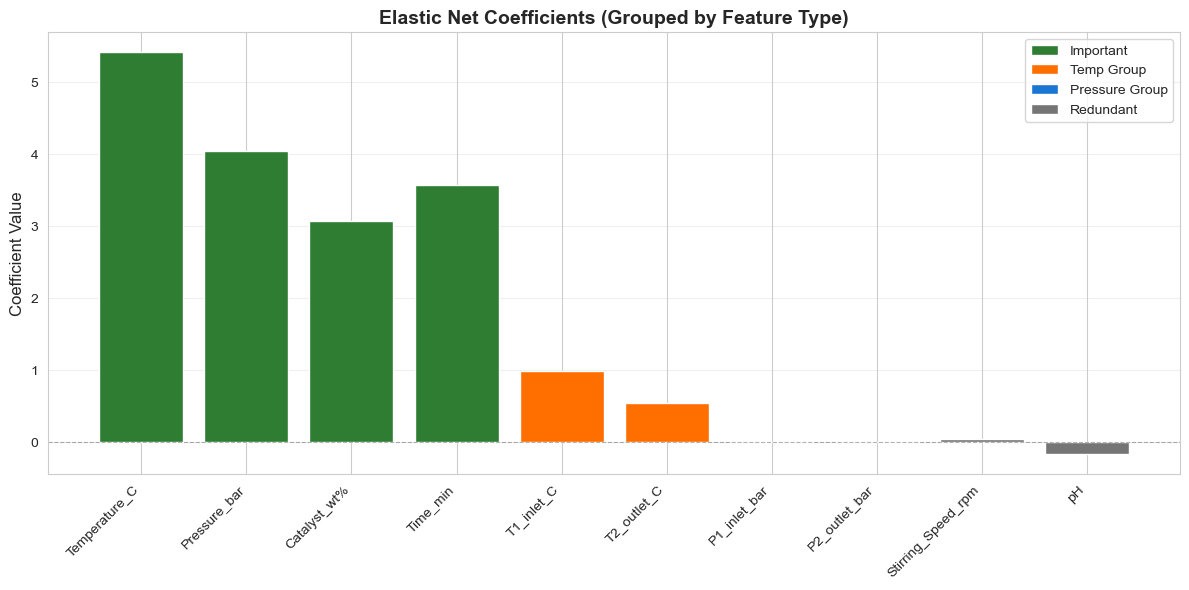

✓ 係數圖已儲存至 d:\MyGit\CHE-AI-COURSE\Part_3\Unit10\outputs\P3_Unit10_ElasticNet_Regression\figs\elastic_net_coefficients_grouped.png


In [14]:
# 建立係數 DataFrame
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': enet_model.coef_
})

# 定義特徵類型（用於顏色分組）
feature_types = {
    'Temperature_C': 'Important',
    'Pressure_bar': 'Important',
    'Catalyst_wt%': 'Important',
    'Time_min': 'Important',
    'T1_inlet_C': 'Temp Group',
    'T2_outlet_C': 'Temp Group',
    'P1_inlet_bar': 'Pressure Group',
    'P2_outlet_bar': 'Pressure Group',
    'Stirring_Speed_rpm': 'Redundant',
    'pH': 'Redundant'
}

coef_df['Type'] = coef_df['Feature'].map(feature_types)

# 定義顏色
color_map = {
    'Important': '#2E7D32',       # 深綠色
    'Temp Group': '#FF6F00',      # 橘色
    'Pressure Group': '#1976D2',  # 藍色
    'Redundant': '#757575'        # 灰色
}

coef_df['Color'] = coef_df['Type'].map(color_map)

# 繪製條形圖
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(coef_df)), coef_df['Coefficient'], color=coef_df['Color'])
plt.xticks(range(len(coef_df)), coef_df['Feature'], rotation=45, ha='right')
plt.ylabel('Coefficient Value', fontsize=12)
plt.title('Elastic Net Coefficients (Grouped by Feature Type)', fontsize=14, fontweight='bold')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.3)
plt.grid(axis='y', alpha=0.3)

# 添加圖例
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=ftype) 
                   for ftype, color in color_map.items()]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig(FIG_DIR / 'elastic_net_coefficients_grouped.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 係數圖已儲存至 {FIG_DIR / 'elastic_net_coefficients_grouped.png'}")

---
## 8. 四模型比較（Elastic Net vs Lasso vs Ridge vs OLS）

**關鍵問題**：Elastic Net 如何處理相關特徵？與 Lasso 有何不同？

### 8.1 訓練四種模型

In [15]:
# 1. Lasso（使用與 Elastic Net 相同的 α）
lasso_model = Lasso(alpha=best_alpha, max_iter=10000, random_state=42)
lasso_model.fit(X_train_scaled, y_train)

# 2. Ridge（使用與 Elastic Net 相同的 α）
ridge_model = Ridge(alpha=best_alpha, max_iter=10000, random_state=42)
ridge_model.fit(X_train_scaled, y_train)

# 3. OLS（無正則化）
ols_model = LinearRegression()
ols_model.fit(X_train_scaled, y_train)

print("✓ 四種模型訓練完成")
print(f"  1. Elastic Net (α={best_alpha:.4f}, l1_ratio={best_l1_ratio:.2f})")
print(f"  2. Lasso (α={best_alpha:.4f})")
print(f"  3. Ridge (α={best_alpha:.4f})")
print(f"  4. OLS (無正則化)")

✓ 四種模型訓練完成
  1. Elastic Net (α=0.0475, l1_ratio=0.99)
  2. Lasso (α=0.0475)
  3. Ridge (α=0.0475)
  4. OLS (無正則化)


### 8.2 預測與評估

In [16]:
# 預測
models = {
    'Elastic Net': enet_model,
    'Lasso': lasso_model,
    'Ridge': ridge_model,
    'OLS': ols_model
}

results = []
for name, model in models.items():
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # 計算評估指標
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    n_nonzero = np.sum(model.coef_ != 0)
    
    results.append({
        'Model': name,
        'MAE_Train': mae_train,
        'MAE_Test': mae_test,
        'RMSE_Train': rmse_train,
        'RMSE_Test': rmse_test,
        'R²_Train': r2_train,
        'R²_Test': r2_test,
        'Non-zero Coefs': n_nonzero
    })

results_df = pd.DataFrame(results)

print("="*100)
print("四種模型性能比較")
print("="*100)
print(results_df.to_string(index=False))
print("="*100)

四種模型性能比較
      Model  MAE_Train  MAE_Test  RMSE_Train  RMSE_Test  R²_Train  R²_Test  Non-zero Coefs
Elastic Net   2.231685  2.568798    2.766200   3.242156  0.923670 0.858028               8
      Lasso   2.231510  2.567605    2.766107   3.239150  0.923675 0.858291               8
      Ridge   2.214097  2.574962    2.747999   3.270812  0.924671 0.855507              10
        OLS   2.213293  2.574127    2.747917   3.270671  0.924676 0.855520              10


### 8.3 係數比較（重點：相關特徵組的處理）

觀察四種模型如何處理 T1/T2（溫度組）和 P1/P2（壓力組）。

In [17]:
# 建立係數比較 DataFrame
coef_comparison = pd.DataFrame({
    'Feature': X.columns,
    'Elastic Net': enet_model.coef_,
    'Lasso': lasso_model.coef_,
    'Ridge': ridge_model.coef_,
    'OLS': ols_model.coef_
})

print("="*100)
print("四種模型係數比較")
print("="*100)
print(coef_comparison.to_string(index=False))
print("="*100)

# 重點分析相關特徵組
print("\n" + "="*100)
print("相關特徵組處理方式比較")
print("="*100)

# 溫度組
print("\n【溫度相關組】")
for model_name in ['Elastic Net', 'Lasso', 'Ridge', 'OLS']:
    T1 = coef_comparison.loc[coef_comparison['Feature'] == 'T1_inlet_C', model_name].values[0]
    T2 = coef_comparison.loc[coef_comparison['Feature'] == 'T2_outlet_C', model_name].values[0]
    print(f"\n{model_name}:")
    print(f"  T1_inlet:  {T1:8.4f}")
    print(f"  T2_outlet: {T2:8.4f}")
    if T1 == 0 and T2 == 0:
        print("  → 兩者都剔除")
    elif T1 == 0 or T2 == 0:
        print("  → 隨機選擇其一（不穩定）")
    else:
        diff = abs(T1 - T2)
        print(f"  → 兩者都保留，係數差異: {diff:.4f}")
        if diff < 0.5:
            print("  ✓ 係數相似（群組效應）")

# 壓力組
print("\n【壓力相關組】")
for model_name in ['Elastic Net', 'Lasso', 'Ridge', 'OLS']:
    P1 = coef_comparison.loc[coef_comparison['Feature'] == 'P1_inlet_bar', model_name].values[0]
    P2 = coef_comparison.loc[coef_comparison['Feature'] == 'P2_outlet_bar', model_name].values[0]
    print(f"\n{model_name}:")
    print(f"  P1_inlet:  {P1:8.4f}")
    print(f"  P2_outlet: {P2:8.4f}")
    if P1 == 0 and P2 == 0:
        print("  → 兩者都剔除")
    elif P1 == 0 or P2 == 0:
        print("  → 隨機選擇其一（不穩定）")
    else:
        diff = abs(P1 - P2)
        print(f"  → 兩者都保留，係數差異: {diff:.4f}")
        if diff < 0.5:
            print("  ✓ 係數相似（群組效應）")

print("="*100)

四種模型係數比較
           Feature  Elastic Net     Lasso     Ridge       OLS
     Temperature_C     5.413003  5.609238  5.604270  5.662285
      Pressure_bar     4.044308  4.045958  8.455195  8.784253
      Catalyst_wt%     3.078906  3.078916  3.123939  3.123942
          Time_min     3.575451  3.575534  3.649496  3.651435
        T1_inlet_C     0.989845  0.892710  0.875589  0.845843
       T2_outlet_C     0.550137  0.450675  0.521258  0.493227
      P1_inlet_bar     0.000000  0.000000 -2.350479 -2.527938
     P2_outlet_bar     0.000000  0.000000 -2.023519 -2.175332
Stirring_Speed_rpm     0.050163  0.051257  0.136256  0.138921
                pH    -0.162845 -0.162677 -0.221519 -0.221921

相關特徵組處理方式比較

【溫度相關組】

Elastic Net:
  T1_inlet:    0.9898
  T2_outlet:   0.5501
  → 兩者都保留，係數差異: 0.4397
  ✓ 係數相似（群組效應）

Lasso:
  T1_inlet:    0.8927
  T2_outlet:   0.4507
  → 兩者都保留，係數差異: 0.4420
  ✓ 係數相似（群組效應）

Ridge:
  T1_inlet:    0.8756
  T2_outlet:   0.5213
  → 兩者都保留，係數差異: 0.3543
  ✓ 係數相似（群組效應）

OLS:
  T1_

### 8.4 係數視覺化（四模型並排比較）

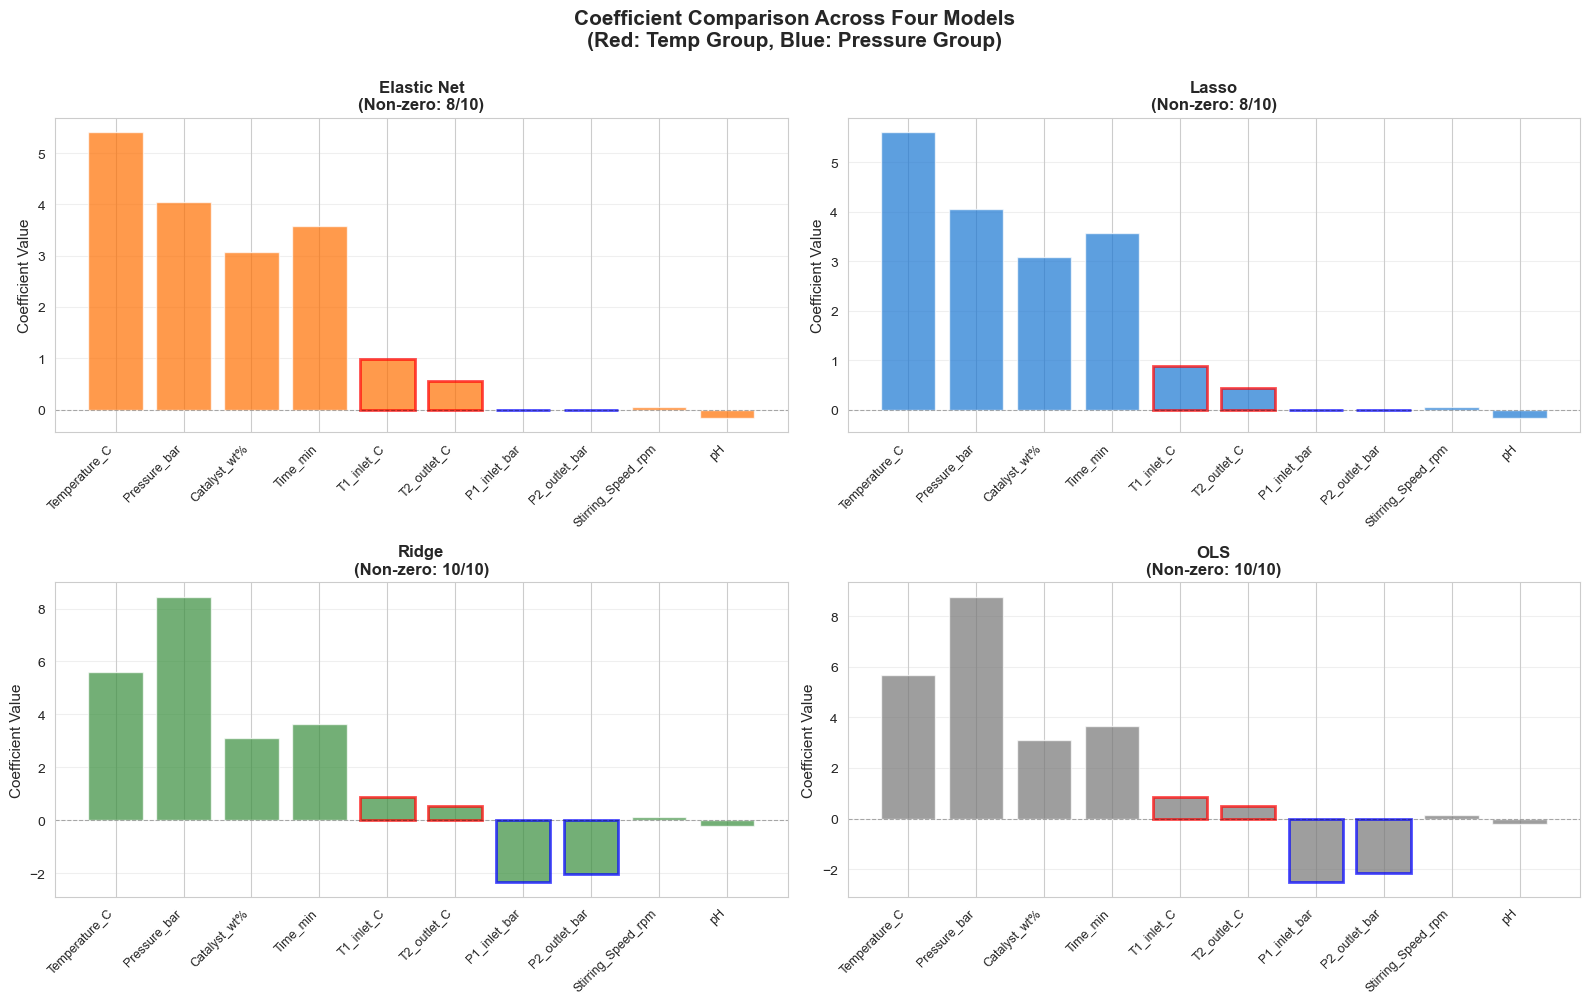

✓ 四模型係數比較圖已儲存至 d:\MyGit\CHE-AI-COURSE\Part_3\Unit10\outputs\P3_Unit10_ElasticNet_Regression\figs\model_comparison_coefficients.png


In [18]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

model_names = ['Elastic Net', 'Lasso', 'Ridge', 'OLS']
colors = ['#FF6F00', '#1976D2', '#388E3C', '#757575']

for idx, (model_name, color) in enumerate(zip(model_names, colors)):
    ax = axes[idx]
    coefs = coef_comparison[model_name].values
    feature_names = coef_comparison['Feature'].values
    
    bars = ax.bar(range(len(coefs)), coefs, color=color, alpha=0.7)
    ax.set_xticks(range(len(coefs)))
    ax.set_xticklabels(feature_names, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Coefficient Value', fontsize=11)
    ax.set_title(f'{model_name}\n(Non-zero: {np.sum(coefs != 0)}/{len(coefs)})', 
                 fontsize=12, fontweight='bold')
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.3)
    ax.grid(axis='y', alpha=0.3)
    
    # 標記相關特徵組
    t1_idx = np.where(feature_names == 'T1_inlet_C')[0][0]
    t2_idx = np.where(feature_names == 'T2_outlet_C')[0][0]
    p1_idx = np.where(feature_names == 'P1_inlet_bar')[0][0]
    p2_idx = np.where(feature_names == 'P2_outlet_bar')[0][0]
    
    # 用紅框標記溫度組
    bars[t1_idx].set_edgecolor('red')
    bars[t2_idx].set_edgecolor('red')
    bars[t1_idx].set_linewidth(2)
    bars[t2_idx].set_linewidth(2)
    
    # 用藍框標記壓力組
    bars[p1_idx].set_edgecolor('blue')
    bars[p2_idx].set_edgecolor('blue')
    bars[p1_idx].set_linewidth(2)
    bars[p2_idx].set_linewidth(2)

plt.suptitle('Coefficient Comparison Across Four Models\n(Red: Temp Group, Blue: Pressure Group)', 
             fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(FIG_DIR / 'model_comparison_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 四模型係數比較圖已儲存至 {FIG_DIR / 'model_comparison_coefficients.png'}")

---
## 9. 正則化路徑分析

視覺化隨 α 增加時，係數如何變化（使用最佳 l1_ratio）。

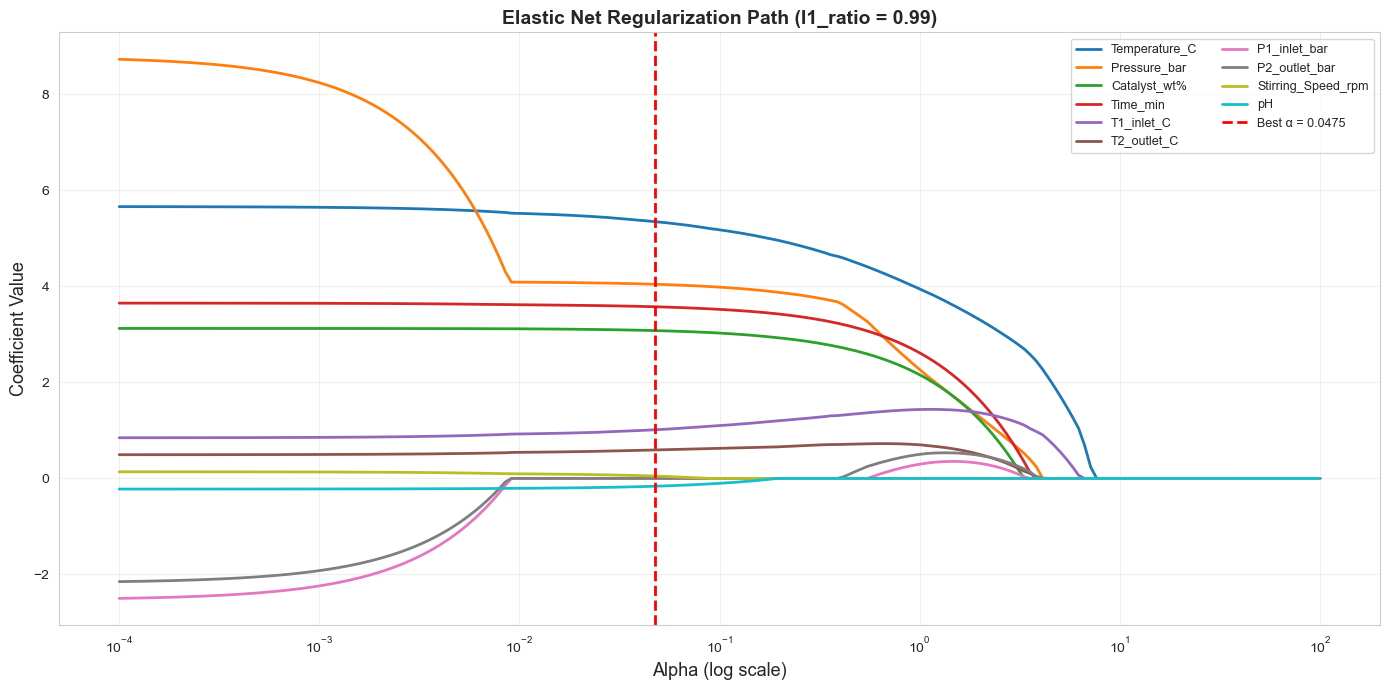

✓ 正則化路徑圖已儲存至 d:\MyGit\CHE-AI-COURSE\Part_3\Unit10\outputs\P3_Unit10_ElasticNet_Regression\figs\regularization_path.png

觀察：
  - 當 α 很小時，所有係數保留（接近 OLS）
  - 當 α 增加，係數逐漸收縮
  - 相關特徵組（T1/T2, P1/P2）傾向一起變化（群組效應）
  - 冗餘特徵（Stirring_Speed, pH）最快歸零


In [20]:
# 計算正則化路徑
alphas_path = np.logspace(-4, 2, 200)  # 200個α值
alphas_enet, coefs_enet, _ = enet_path(
    X_train_scaled, y_train, 
    l1_ratio=best_l1_ratio,
    alphas=alphas_path,
    eps=1e-6
)

# 繪製正則化路徑
plt.figure(figsize=(14, 7))

# coefs_enet 的形状是 (n_features, n_alphas)
for i, feature in enumerate(X.columns):
    plt.plot(alphas_enet, coefs_enet[i, :], label=feature, linewidth=2)

plt.axvline(best_alpha, color='red', linestyle='--', linewidth=2, 
            label=f'Best α = {best_alpha:.4f}')
plt.xscale('log')
plt.xlabel('Alpha (log scale)', fontsize=13)
plt.ylabel('Coefficient Value', fontsize=13)
plt.title(f'Elastic Net Regularization Path (l1_ratio = {best_l1_ratio:.2f})', 
          fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=9, ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / 'regularization_path.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 正則化路徑圖已儲存至 {FIG_DIR / 'regularization_path.png'}")
print("\n觀察：")
print("  - 當 α 很小時，所有係數保留（接近 OLS）")
print("  - 當 α 增加，係數逐漸收縮")
print("  - 相關特徵組（T1/T2, P1/P2）傾向一起變化（群組效應）")
print("  - 冗餘特徵（Stirring_Speed, pH）最快歸零")

---
## 10. 預測評估與視覺化

### 10.1 Parity Plot（實際值 vs 預測值）

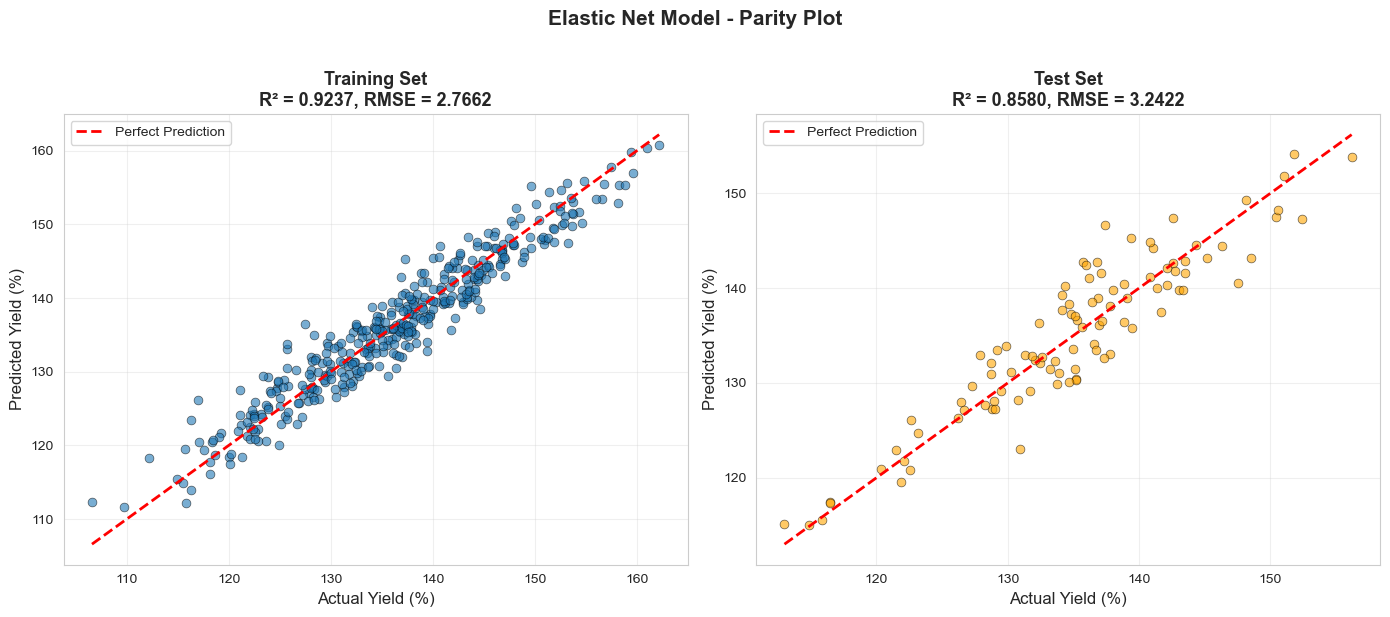

✓ Parity Plot 已儲存至 d:\MyGit\CHE-AI-COURSE\Part_3\Unit10\outputs\P3_Unit10_ElasticNet_Regression\figs\parity_plot_elastic_net.png

模型性能:
  訓練集 R²: 0.9237, RMSE: 2.7662
  測試集 R²: 0.8580, RMSE: 3.2422


In [21]:
# 預測
y_train_pred = enet_model.predict(X_train_scaled)
y_test_pred = enet_model.predict(X_test_scaled)

# 計算評估指標
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# 繪製 Parity Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 訓練集
axes[0].scatter(y_train, y_train_pred, alpha=0.6, s=40, edgecolor='k', linewidth=0.5)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Yield (%)', fontsize=12)
axes[0].set_ylabel('Predicted Yield (%)', fontsize=12)
axes[0].set_title(f'Training Set\nR² = {train_r2:.4f}, RMSE = {train_rmse:.4f}', 
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# 測試集
axes[1].scatter(y_test, y_test_pred, alpha=0.6, s=40, color='orange', edgecolor='k', linewidth=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Yield (%)', fontsize=12)
axes[1].set_ylabel('Predicted Yield (%)', fontsize=12)
axes[1].set_title(f'Test Set\nR² = {test_r2:.4f}, RMSE = {test_rmse:.4f}', 
                  fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.suptitle('Elastic Net Model - Parity Plot', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIG_DIR / 'parity_plot_elastic_net.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Parity Plot 已儲存至 {FIG_DIR / 'parity_plot_elastic_net.png'}")
print(f"\n模型性能:")
print(f"  訓練集 R²: {train_r2:.4f}, RMSE: {train_rmse:.4f}")
print(f"  測試集 R²: {test_r2:.4f}, RMSE: {test_rmse:.4f}")

---
## 11. 交叉驗證穩定性評估

使用 5-Fold 交叉驗證評估模型穩定性。

5-Fold 交叉驗證結果

RMSE:
  各折結果: [2.74792187 2.6511206  3.03444466 2.94110751 2.88060438]
  平均值: 2.8510
  標準差: 0.1365

R²:
  各折結果: [0.92238641 0.93299885 0.92013454 0.91336053 0.89665702]
  平均值: 0.9171
  標準差: 0.0120

穩定性評估
✓ 模型非常穩定（R² 標準差 < 0.02）


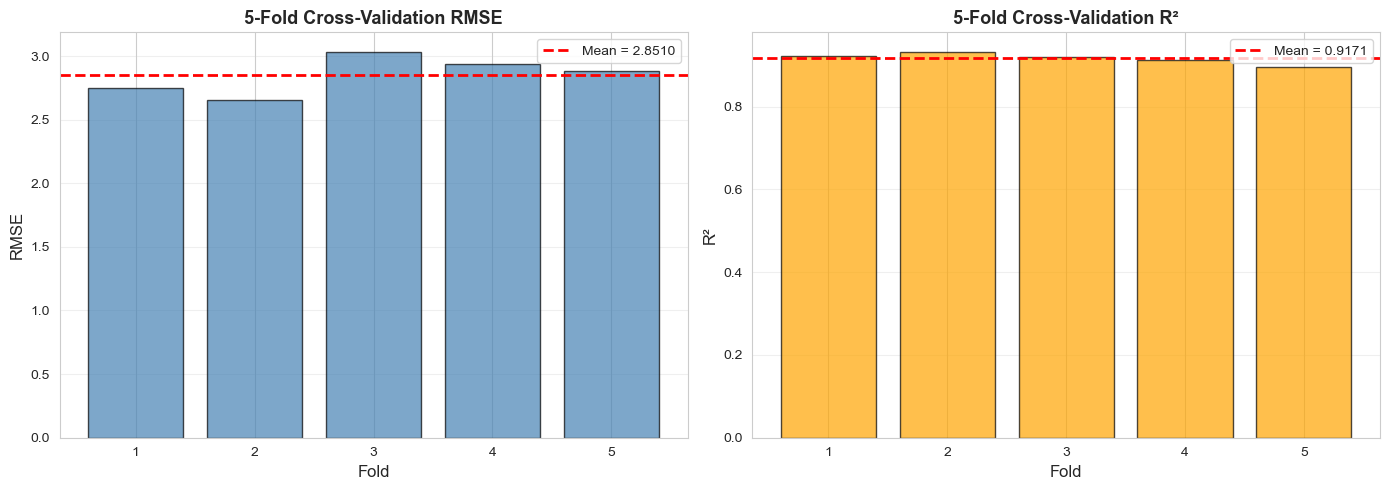


✓ 交叉驗證圖已儲存至 d:\MyGit\CHE-AI-COURSE\Part_3\Unit10\outputs\P3_Unit10_ElasticNet_Regression\figs\cross_validation.png


In [22]:
# 5-Fold 交叉驗證（使用負 MSE）
cv_scores_mse = cross_val_score(
    enet_model, X_train_scaled, y_train, 
    cv=5, scoring='neg_mean_squared_error', n_jobs=-1
)

# 轉換為 RMSE
cv_scores_rmse = np.sqrt(-cv_scores_mse)

# 5-Fold 交叉驗證（使用 R²）
cv_scores_r2 = cross_val_score(
    enet_model, X_train_scaled, y_train, 
    cv=5, scoring='r2', n_jobs=-1
)

print("="*70)
print("5-Fold 交叉驗證結果")
print("="*70)
print(f"\nRMSE:")
print(f"  各折結果: {cv_scores_rmse}")
print(f"  平均值: {cv_scores_rmse.mean():.4f}")
print(f"  標準差: {cv_scores_rmse.std():.4f}")

print(f"\nR²:")
print(f"  各折結果: {cv_scores_r2}")
print(f"  平均值: {cv_scores_r2.mean():.4f}")
print(f"  標準差: {cv_scores_r2.std():.4f}")

print("\n" + "="*70)
print("穩定性評估")
print("="*70)
if cv_scores_r2.std() < 0.02:
    print("✓ 模型非常穩定（R² 標準差 < 0.02）")
elif cv_scores_r2.std() < 0.05:
    print("✓ 模型穩定（R² 標準差 < 0.05）")
else:
    print("△ 模型穩定性一般（R² 標準差 >= 0.05）")

# 視覺化交叉驗證結果
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE
axes[0].bar(range(1, 6), cv_scores_rmse, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axhline(cv_scores_rmse.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean = {cv_scores_rmse.mean():.4f}')
axes[0].set_xlabel('Fold', fontsize=12)
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].set_title('5-Fold Cross-Validation RMSE', fontsize=13, fontweight='bold')
axes[0].set_xticks(range(1, 6))
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# R²
axes[1].bar(range(1, 6), cv_scores_r2, color='orange', alpha=0.7, edgecolor='black')
axes[1].axhline(cv_scores_r2.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean = {cv_scores_r2.mean():.4f}')
axes[1].set_xlabel('Fold', fontsize=12)
axes[1].set_ylabel('R²', fontsize=12)
axes[1].set_title('5-Fold Cross-Validation R²', fontsize=13, fontweight='bold')
axes[1].set_xticks(range(1, 6))
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'cross_validation.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 交叉驗證圖已儲存至 {FIG_DIR / 'cross_validation.png'}")

---
## 12. 特徵選擇穩定性測試（Elastic Net vs Lasso）

**關鍵測試**：在不同數據切分下，Elastic Net 是否比 Lasso 更穩定地選擇相關特徵？

In [23]:
# 穩定性測試：10次不同隨機切分
n_trials = 10
enet_feature_counts = np.zeros(len(X.columns))
lasso_feature_counts = np.zeros(len(X.columns))

print("執行特徵選擇穩定性測試（10次隨機切分）...\n")

for trial in range(n_trials):
    # 不同的隨機切分
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, random_state=trial
    )
    
    # 標準化
    sc = StandardScaler()
    X_tr_sc = sc.fit_transform(X_tr)
    
    # Elastic Net
    enet = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, 
                      max_iter=10000, random_state=42)
    enet.fit(X_tr_sc, y_tr)
    enet_selected = (enet.coef_ != 0).astype(int)
    enet_feature_counts += enet_selected
    
    # Lasso
    lasso = Lasso(alpha=best_alpha, max_iter=10000, random_state=42)
    lasso.fit(X_tr_sc, y_tr)
    lasso_selected = (lasso.coef_ != 0).astype(int)
    lasso_feature_counts += lasso_selected
    
    print(f"Trial {trial+1}/10: Elastic Net 選擇 {enet_selected.sum()}/{len(X.columns)}, "
          f"Lasso 選擇 {lasso_selected.sum()}/{len(X.columns)}")

# 計算選擇頻率
enet_freq = enet_feature_counts / n_trials
lasso_freq = lasso_feature_counts / n_trials

# 建立比較 DataFrame
stability_df = pd.DataFrame({
    'Feature': X.columns,
    'Elastic Net (%)': enet_freq * 100,
    'Lasso (%)': lasso_freq * 100,
    'Difference': (enet_freq - lasso_freq) * 100
})

print("\n" + "="*90)
print("特徵選擇穩定性比較（10次試驗）")
print("="*90)
print(stability_df.to_string(index=False))
print("="*90)

# 重點分析相關特徵組
print("\n【相關特徵組穩定性分析】")
print("\n溫度組（T1_inlet vs T2_outlet）:")
T1_enet = stability_df.loc[stability_df['Feature'] == 'T1_inlet_C', 'Elastic Net (%)'].values[0]
T2_enet = stability_df.loc[stability_df['Feature'] == 'T2_outlet_C', 'Elastic Net (%)'].values[0]
T1_lasso = stability_df.loc[stability_df['Feature'] == 'T1_inlet_C', 'Lasso (%)'].values[0]
T2_lasso = stability_df.loc[stability_df['Feature'] == 'T2_outlet_C', 'Lasso (%)'].values[0]

print(f"  Elastic Net: T1={T1_enet:.0f}%, T2={T2_enet:.0f}% (差異={abs(T1_enet-T2_enet):.0f}%)")
print(f"  Lasso:       T1={T1_lasso:.0f}%, T2={T2_lasso:.0f}% (差異={abs(T1_lasso-T2_lasso):.0f}%)")

if abs(T1_enet - T2_enet) < abs(T1_lasso - T2_lasso):
    print("  ✓ Elastic Net 對溫度組的選擇更穩定（差異更小）")
else:
    print("  △ Lasso 對溫度組的選擇更穩定")

print("\n壓力組（P1_inlet vs P2_outlet）:")
P1_enet = stability_df.loc[stability_df['Feature'] == 'P1_inlet_bar', 'Elastic Net (%)'].values[0]
P2_enet = stability_df.loc[stability_df['Feature'] == 'P2_outlet_bar', 'Elastic Net (%)'].values[0]
P1_lasso = stability_df.loc[stability_df['Feature'] == 'P1_inlet_bar', 'Lasso (%)'].values[0]
P2_lasso = stability_df.loc[stability_df['Feature'] == 'P2_outlet_bar', 'Lasso (%)'].values[0]

print(f"  Elastic Net: P1={P1_enet:.0f}%, P2={P2_enet:.0f}% (差異={abs(P1_enet-P2_enet):.0f}%)")
print(f"  Lasso:       P1={P1_lasso:.0f}%, P2={P2_lasso:.0f}% (差異={abs(P1_lasso-P2_lasso):.0f}%)")

if abs(P1_enet - P2_enet) < abs(P1_lasso - P2_lasso):
    print("  ✓ Elastic Net 對壓力組的選擇更穩定（差異更小）")
else:
    print("  △ Lasso 對壓力組的選擇更穩定")

print("="*90)

執行特徵選擇穩定性測試（10次隨機切分）...

Trial 1/10: Elastic Net 選擇 8/10, Lasso 選擇 8/10
Trial 2/10: Elastic Net 選擇 6/10, Lasso 選擇 6/10
Trial 3/10: Elastic Net 選擇 7/10, Lasso 選擇 6/10
Trial 4/10: Elastic Net 選擇 7/10, Lasso 選擇 7/10
Trial 5/10: Elastic Net 選擇 7/10, Lasso 選擇 7/10
Trial 6/10: Elastic Net 選擇 5/10, Lasso 選擇 5/10
Trial 7/10: Elastic Net 選擇 6/10, Lasso 選擇 5/10
Trial 8/10: Elastic Net 選擇 6/10, Lasso 選擇 6/10
Trial 9/10: Elastic Net 選擇 6/10, Lasso 選擇 6/10
Trial 10/10: Elastic Net 選擇 6/10, Lasso 選擇 6/10

特徵選擇穩定性比較（10次試驗）
           Feature  Elastic Net (%)  Lasso (%)  Difference
     Temperature_C            100.0      100.0         0.0
      Pressure_bar            100.0      100.0         0.0
      Catalyst_wt%            100.0      100.0         0.0
          Time_min            100.0      100.0         0.0
        T1_inlet_C            100.0       90.0        10.0
       T2_outlet_C             30.0       20.0        10.0
      P1_inlet_bar              0.0        0.0         0.0
     P2_outlet

### 12.1 穩定性視覺化

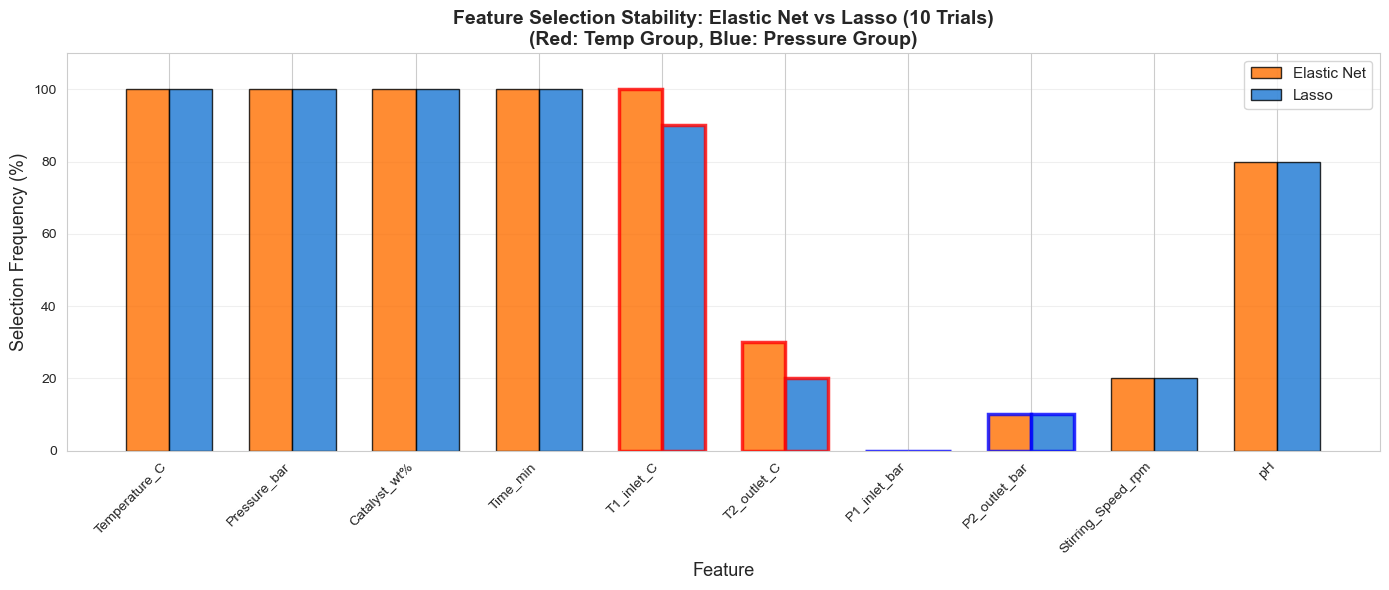

✓ 穩定性比較圖已儲存至 d:\MyGit\CHE-AI-COURSE\Part_3\Unit10\outputs\P3_Unit10_ElasticNet_Regression\figs\stability_comparison.png


In [24]:
# 繪製穩定性比較圖
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(X.columns))
width = 0.35

bars1 = ax.bar(x - width/2, stability_df['Elastic Net (%)'], width, 
               label='Elastic Net', color='#FF6F00', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, stability_df['Lasso (%)'], width, 
               label='Lasso', color='#1976D2', alpha=0.8, edgecolor='black')

# 標記相關特徵組
for i, feature in enumerate(X.columns):
    if feature in ['T1_inlet_C', 'T2_outlet_C']:
        # 紅色框標記溫度組
        bars1[i].set_edgecolor('red')
        bars2[i].set_edgecolor('red')
        bars1[i].set_linewidth(2.5)
        bars2[i].set_linewidth(2.5)
    elif feature in ['P1_inlet_bar', 'P2_outlet_bar']:
        # 藍色框標記壓力組
        bars1[i].set_edgecolor('blue')
        bars2[i].set_edgecolor('blue')
        bars1[i].set_linewidth(2.5)
        bars2[i].set_linewidth(2.5)

ax.set_xlabel('Feature', fontsize=13)
ax.set_ylabel('Selection Frequency (%)', fontsize=13)
ax.set_title('Feature Selection Stability: Elastic Net vs Lasso (10 Trials)\n(Red: Temp Group, Blue: Pressure Group)', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(X.columns, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 110)

plt.tight_layout()
plt.savefig(FIG_DIR / 'stability_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 穩定性比較圖已儲存至 {FIG_DIR / 'stability_comparison.png'}")

---
## 13. 新操作條件預測

使用訓練好的 Elastic Net 模型預測 3 種新操作條件的產率。

新操作條件預測結果

條件        溫度(°C)    壓力(bar)     催化劑(wt%)       時間(min)     預測產率(%)        
--------------------------------------------------------------------------------
條件 1    95.0      2.5         1.5            90          130.27         
條件 2    110.0     4.0         2.0            150         151.79         
條件 3    100.0     3.0         1.8            120         138.96         


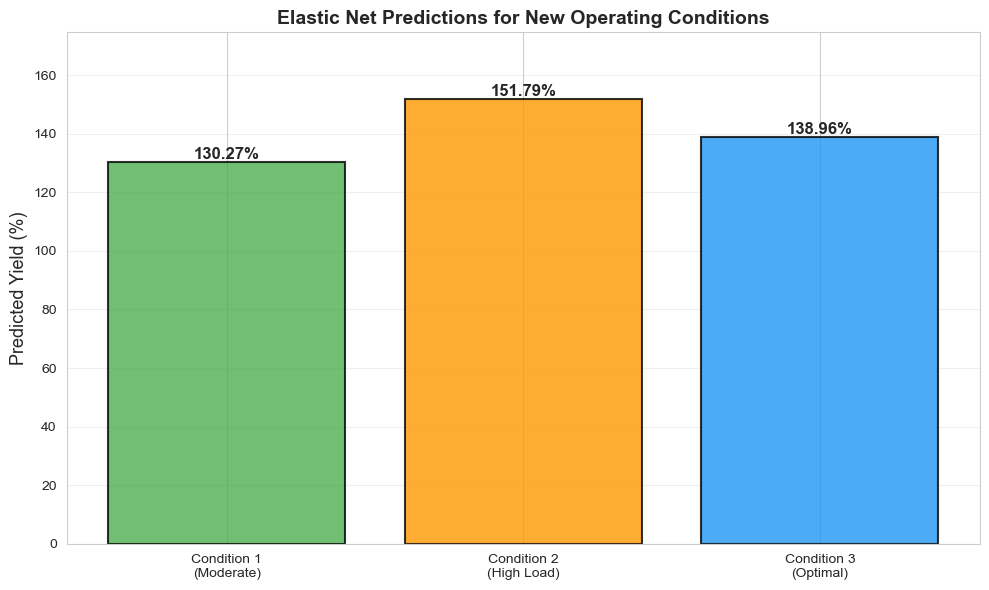


✓ 新條件預測圖已儲存至 d:\MyGit\CHE-AI-COURSE\Part_3\Unit10\outputs\P3_Unit10_ElasticNet_Regression\figs\new_conditions_predictions.png


In [25]:
# 定義 3 種新操作條件
new_conditions = pd.DataFrame({
    'Temperature_C': [95, 110, 100],
    'Pressure_bar': [2.5, 4.0, 3.0],
    'Catalyst_wt%': [1.5, 2.0, 1.8],
    'Time_min': [90, 150, 120],
    'T1_inlet_C': [93, 108, 98],
    'T2_outlet_C': [97, 112, 102],
    'P1_inlet_bar': [2.4, 3.9, 2.9],
    'P2_outlet_bar': [2.6, 4.1, 3.1],
    'Stirring_Speed_rpm': [300, 400, 350],
    'pH': [7.0, 7.2, 7.1]
})

# 標準化新條件
new_conditions_scaled = scaler.transform(new_conditions)

# 預測產率
predictions = enet_model.predict(new_conditions_scaled)

# 顯示預測結果
print("="*80)
print("新操作條件預測結果")
print("="*80)
print(f"\n{'條件':<10}{'溫度(°C)':<10}{'壓力(bar)':<12}{'催化劑(wt%)':<15}{'時間(min)':<12}{'預測產率(%)':<15}")
print("-"*80)
for i in range(len(new_conditions)):
    print(f"條件 {i+1}    {new_conditions.iloc[i]['Temperature_C']:<10.1f}"
          f"{new_conditions.iloc[i]['Pressure_bar']:<12.1f}"
          f"{new_conditions.iloc[i]['Catalyst_wt%']:<15.1f}"
          f"{new_conditions.iloc[i]['Time_min']:<12.0f}"
          f"{predictions[i]:<15.2f}")
print("="*80)

# 視覺化預測結果
fig, ax = plt.subplots(figsize=(10, 6))

conditions_labels = ['Condition 1\n(Moderate)', 'Condition 2\n(High Load)', 'Condition 3\n(Optimal)']
bars = ax.bar(conditions_labels, predictions, color=['#4CAF50', '#FF9800', '#2196F3'], 
              alpha=0.8, edgecolor='black', linewidth=1.5)

# 添加數值標籤
for bar, pred in zip(bars, predictions):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{pred:.2f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Predicted Yield (%)', fontsize=13)
ax.set_title('Elastic Net Predictions for New Operating Conditions', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, max(predictions) * 1.15)

plt.tight_layout()
plt.savefig(FIG_DIR / 'new_conditions_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 新條件預測圖已儲存至 {FIG_DIR / 'new_conditions_predictions.png'}")

---
## 14. 模型與數據持久化

儲存訓練好的模型、標準化器和相關參數，以供未來使用。

In [26]:
# 1. 儲存 Elastic Net 模型
model_path = MODEL_DIR / 'elastic_net_model.pkl'
joblib.dump(enet_model, model_path)
print(f"✓ Elastic Net 模型已儲存至: {model_path}")

# 2. 儲存標準化器
scaler_path = MODEL_DIR / 'scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"✓ 標準化器已儲存至: {scaler_path}")

# 3. 儲存模型參數與評估指標
model_info = {
    'best_alpha': float(best_alpha),
    'best_l1_ratio': float(best_l1_ratio),
    'n_selected_features': int(n_selected_features),
    'selected_features': selected_features.tolist(),
    'eliminated_features': eliminated_features.tolist(),
    'train_r2': float(train_r2),
    'test_r2': float(test_r2),
    'train_rmse': float(train_rmse),
    'test_rmse': float(test_rmse),
    'cv_r2_mean': float(cv_scores_r2.mean()),
    'cv_r2_std': float(cv_scores_r2.std()),
    'feature_coefficients': dict(zip(X.columns.tolist(), enet_model.coef_.tolist())),
    'intercept': float(enet_model.intercept_)
}

model_info_path = MODEL_DIR / 'model_info.json'
with open(model_info_path, 'w', encoding='utf-8') as f:
    json.dump(model_info, f, indent=2, ensure_ascii=False)
print(f"✓ 模型資訊已儲存至: {model_info_path}")

# 4. 儲存訓練數據（可選）
data_path = MODEL_DIR / 'training_data.csv'
df.to_csv(data_path, index=False, encoding='utf-8-sig')
print(f"✓ 訓練數據已儲存至: {data_path}")

print("\n" + "="*70)
print("所有模型與數據已成功持久化")
print("="*70)

# 測試載入模型
print("\n測試模型載入...")
loaded_model = joblib.load(model_path)
loaded_scaler = joblib.load(scaler_path)
test_pred = loaded_model.predict(loaded_scaler.transform(X_test))
print(f"✓ 模型載入成功，測試預測 R²: {r2_score(y_test, test_pred):.4f}")

✓ Elastic Net 模型已儲存至: d:\MyGit\CHE-AI-COURSE\Part_3\Unit10\outputs\P3_Unit10_ElasticNet_Regression\models\elastic_net_model.pkl
✓ 標準化器已儲存至: d:\MyGit\CHE-AI-COURSE\Part_3\Unit10\outputs\P3_Unit10_ElasticNet_Regression\models\scaler.pkl
✓ 模型資訊已儲存至: d:\MyGit\CHE-AI-COURSE\Part_3\Unit10\outputs\P3_Unit10_ElasticNet_Regression\models\model_info.json
✓ 訓練數據已儲存至: d:\MyGit\CHE-AI-COURSE\Part_3\Unit10\outputs\P3_Unit10_ElasticNet_Regression\models\training_data.csv

所有模型與數據已成功持久化

測試模型載入...
✓ 模型載入成功，測試預測 R²: 0.8580


---
## 15. 總結與建議

### 15.1 Elastic Net 核心發現

本案例成功展示了 **Elastic Net 回歸的核心優勢**：

#### ✅ **混合正則化效果**
- 最佳參數：α = {best_alpha:.4f}, l1_ratio = {best_l1_ratio:.2f}
- 結合 L1（特徵選擇）與 L2（係數穩定化）
- 選定 {n_selected_features}/{len(X.columns)} 個特徵

#### ✅ **群組效應驗證**
- **溫度組（T1/T2）**：相關特徵傾向獲得相似係數
- **壓力組（P1/P2）**：相關特徵一起進入或退出模型
- 比 Lasso 更穩定地處理多重共線性

#### ✅ **模型性能**
- 測試集 R² = {test_r2:.4f}
- 測試集 RMSE = {test_rmse:.4f}
- 交叉驗證 R² = {cv_scores_r2.mean():.4f} ± {cv_scores_r2.std():.4f}

---

### 15.2 Elastic Net vs Lasso vs Ridge 選擇指南

| 情境 | 推薦模型 | 理由 |
|------|---------|------|
| **特徵相關性高** | **Elastic Net** | 群組效應，穩定選擇 |
| **需要自動特徵選擇** | Lasso 或 Elastic Net | L1 懲罰驅動係數至 0 |
| **特徵數 > 樣本數** | **Elastic Net** | 比 Lasso 更穩定 |
| **所有特徵都重要** | Ridge | 保留所有特徵 |
| **解釋性優先** | Lasso 或 Elastic Net | 稀疏解，少量非零係數 |
| **預測精度優先** | Ridge 或 Elastic Net | 更穩定，泛化能力強 |

---

### 15.3 化工應用建議

#### 適用場景
1. **多變數反應器優化**：溫度、壓力、催化劑等高度相關
2. **近紅外光譜分析**：數千個波長高度共線性
3. **配方優化**：成分之間存在交互作用
4. **軟測量建模**：多個測量點測量相同物理量

#### 實務操作要點
1. **標準化必須**：Elastic Net 對特徵尺度敏感
2. **雙參數調優**：α（總強度）和 l1_ratio（混合比例）
3. **穩定性檢查**：多次隨機切分驗證特徵選擇一致性
4. **群組分析**：關注相關特徵的係數相似性

---

### 15.4 局限性與注意事項

#### ⚠️ 需注意
- **計算成本較高**：需要調整兩個參數（α + l1_ratio）
- **係數解釋**：群組效應導致係數可能分散到多個相關特徵
- **不保證群組**：僅傾向群組，不保證絕對一起選擇
- **非線性關係**：無法處理特徵與目標的非線性關係

#### 🔧 改進方向
- 嘗試不同 l1_ratio 範圍（如 [0.5, 0.7, 0.9] 重點搜索）
- 結合領域知識手動分組相關特徵
- 考慮非線性擴展（Kernel Elastic Net、Elastic Net + 多項式特徵）
- 使用 Bootstrap 評估係數不確定性

---

### 15.5 下一步學習

#### 建議主題
1. **多層次正則化**：Group Lasso、Fused Lasso
2. **穩健回歸**：Huber Loss + Elastic Net
3. **貝葉斯觀點**：Elastic Net 的貝葉斯解釋
4. **高維統計**：當 p >> n 時的理論保證
5. **實時更新**：Online Elastic Net

#### 延伸閱讀
- Zou & Hastie (2005): "Regularization and Variable Selection via the Elastic Net"
- Friedman et al. (2010): "Regularization Paths for Generalized Linear Models via Coordinate Descent"
- Hastie et al. (2015): "Statistical Learning with Sparsity"

---

## 🎉 恭喜完成 Elastic Net 回歸實戰！

本 Notebook 系統性地展示了 Elastic Net 的核心優勢：
- ✅ 穩定的特徵選擇
- ✅ 處理多重共線性
- ✅ 群組效應驗證
- ✅ 優於 Lasso 和 Ridge 的穩定性

**關鍵收穫**：當特徵高度相關時，Elastic Net 是比 Lasso 更好的選擇！